# Titanic 
Hello and welcome to my code for the Titanic dataset from Kaggle! This code is aimed at exploring the dataset and making predictions about the survival of the passengers using machine learning techniques.

In this code, I have used Python and popular libraries such as Pandas, NumPy, and Scikit-Learn to preprocess the data, perform feature engineering, and build a predictive model. The dataset contains information about the passengers aboard the Titanic, including their age, gender, ticket class, fare, and survival status.

After cleaning and exploring the data, I have used various machine learning algorithms, such as Logistic Regression, Decision Trees, and Random Forests, to build and evaluate predictive models.


## Table of Contents

* [Introduction](#section-one)
    - [Loading of dataset](#subsection-one)
* [Exploratory Data Analysis](#section-two)
    - [Exploration of data](#subsection-two)
    - [Analysis of data](#subsection-three)
    - [Transformation of data](#subsection-four)
* [Modelling and predicting](#section-three)
    - [Cross validation and Gridsearch](#subsection-five)
* [Submission](#section-four)
* [Conclusion](#section-five)

<a id="section-one"></a>
# Introduction
The Titanic dataset available on Kaggle is a classic binary classification problem. The aim is to predict whether a passenger aboard the Titanic survived or not based on various attributes such as their age, gender, ticket class, etc.

The Titanic dataset contains information on 891 passengers out of the 2224 people on board the Titanic. Each passenger is described by the following features:

**PassengerId**: A unique identifier for each passenger.\
**Survived**: A binary variable indicating whether the passenger survived or not (0 = No, 1 = Yes).\
**Pclass**: The ticket class of the passenger (1 = 1st class, 2 = 2nd class, 3 = 3rd class).\
**Name**: The name of the passenger.\
**Sex**: The gender of the passenger.\
**Age**: The age of the passenger in years.\
**SibSp**: The number of siblings/spouses aboard the Titanic.\
**Parch**: The number of parents/children aboard the Titanic.\
**Ticket**: The ticket number of the passenger.\
**Fare**: The fare paid by the passenger.\
**Cabin**: The cabin number of the passenger.\
**Embarked**: The port of embarkation (C = Cherbourg, Q =
Queenstown, S = Southampton).


<a id="subsection-one"></a>
### Load data and importing libraries

In [45]:
# Data analysis 
import pandas as pd
import numpy as np
import random as rnd

# Visualization of data
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Machine learning
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [46]:
# Loading train data and test data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

<a id="section-two"></a>
## Exploratory Data Analysis (EDA)

<a id="subsection-two"></a>

### Exploration of data
Let's take a look at the train_data to understand more about it.

In [47]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [48]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [49]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [50]:
# Look for missing data
train_df.isnull().sum() #checking for total null values

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [51]:
test_df.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In the train data, 'Age', 'Cabin', 'Embarked' contains null values and it is important to deal with it before selecting features. 

It is also noted that the test data might contain null values and have to handle it before predicting.

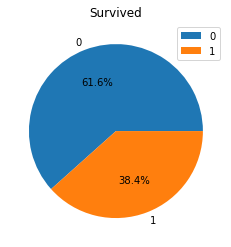

In [52]:
# Get the count of passengers who survived 
survive = train_df.Survived.value_counts()

# Create a pie chart with the survival counts 
plt.pie(survive, labels=survive.index, autopct='%1.1f%%')

# Set the title of the chart
plt.title("Survived")

# Add a legend to the chart
plt.legend()

# Show the chart
plt.show()


Only 38.4% of the passengers survived. To find out how the features are related to the survival of the passengers, we will start to do some analysis.

<a id="subsection-three"></a>

### Analysis of data

After conducting our exploratory data analysis, we have identified several features that warrant further investigation. These features include Pclass, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, and Embarked.

#### PassengerId

The PassengerId is the unique identifier for each passenger which has no relation to whether the passenger survives. Thus this column will dropped.

#### Pclass

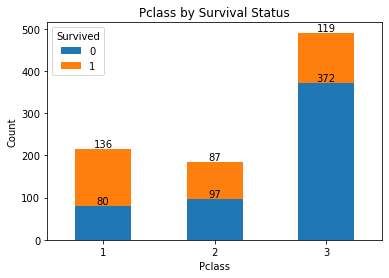

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [53]:
# Group the data by sex and survival status
counts = train_df.groupby(['Pclass', 'Survived']).size().unstack()

# Create a stacked bar chart showing the counts of males and females by survival status
ax = counts.plot(kind='bar', stacked=True)

# Set the title and axis labels
plt.title('Pclass by Survival Status')
plt.xlabel('Pclass')
plt.xticks(rotation=0)
plt.ylabel('Count')

# Add labels to the top of each bar showing the count
for rect in ax.containers:
    ax.bar_label(rect, labels=[f'{int(h)}' for h in rect.datavalues], label_type='edge')

# Add a legend
ax.legend(title='Survived', loc='upper left')
plt.show()

train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

It is clear that the Pclass is an important feature to predict who survive as the survival rate of Pclass 3 is so much lower than the other classes. It can be due to the priority given to them or the location of their cabin.

#### Name

Looking at the head of Name, it seems like this feature cannot be used as a feature to predict survivability of the passengers. This would be dropped when transforming the data.

#### Sex

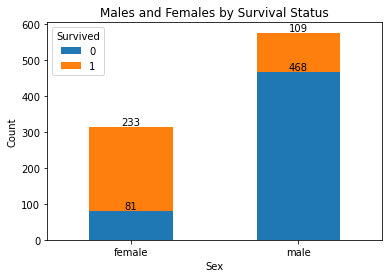

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [54]:
# Group the data by sex and survival status
counts = train_df.groupby(['Sex', 'Survived']).size().unstack()

# Create a stacked bar chart showing the counts of males and females by survival status
ax = counts.plot(kind='bar', stacked=True)

# Set the title and axis labels
plt.title('Males and Females by Survival Status')
plt.xlabel('Sex')
plt.xticks(rotation=0)
plt.ylabel('Count')

# Add labels to the top of each bar showing the count
for rect in ax.containers:
    ax.bar_label(rect, labels=[f'{int(h)}' for h in rect.datavalues], label_type='edge')

# Add a legend
ax.legend(title='Survived', loc='upper left')
plt.show()

# Group by Sex to get the mean of survival rate
train_df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

Base on the data, it can be established that the female rate of survival is a lot higher than male. Thus sex is also an important feature to select.

#### Age

From the EDA, we saw that our train_df age has 177 missing data while test_df has 86 missing data. We can choose to ignore it or fill it in with a data, either imputing it with the median or the mean. However, as the passenger name salutation gives us a hint on what their age roughly should be, we can use it to have a better imputation. 

In [55]:
# Extracting the salutations from the name
train_df['Initial']=0
for i in train_df:
    train_df['Initial']=train_df.Name.str.extract('([A-Za-z]+)\.')

# Checking the salutations with the sex
pd.crosstab(train_df.Initial,train_df.Sex).T.style.background_gradient()

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


The initial has high-cardinality at this moment, so it is best to replace initials with similar group.

In [56]:
# Changing the initials of train_df
train_df['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)
# Checking the mean age of the intials
train_df.groupby('Initial').Age.mean()

Initial
Master     4.574167
Miss      21.860000
Mr        32.739609
Mrs       35.981818
Other     45.888889
Name: Age, dtype: float64

In [57]:
# Imputing the NaN age with respective salutation mean age
age_mapping = {'Mr': 33, 'Mrs': 36, 'Master': 5, 'Miss': 22, 'Other': 46}
train_df['Age'] = train_df['Age'].fillna(train_df['Initial'].map(age_mapping))

In [58]:
# Extracting the salutations from the name of test_df
test_df['Initial']=0
for i in test_df:
    test_df['Initial']=test_df.Name.str.extract('([A-Za-z]+)\.')

# Changing the initials of test_df
test_df['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)
# Checking the mean age of the intials
test_df.groupby('Initial').Age.mean()

Initial
Dona      39.000000
Master     7.406471
Miss      21.774844
Mr        32.114130
Mrs       38.903226
Other     42.750000
Name: Age, dtype: float64

In [59]:
# Imputing the NaN age with respective salutation mean age
age_mapping = {'Mr': 32, 'Mrs': 39, 'Master': 7, 'Miss': 22, 'Other': 43}
test_df['Age'] = test_df['Age'].fillna(test_df['Initial'].map(age_mapping))

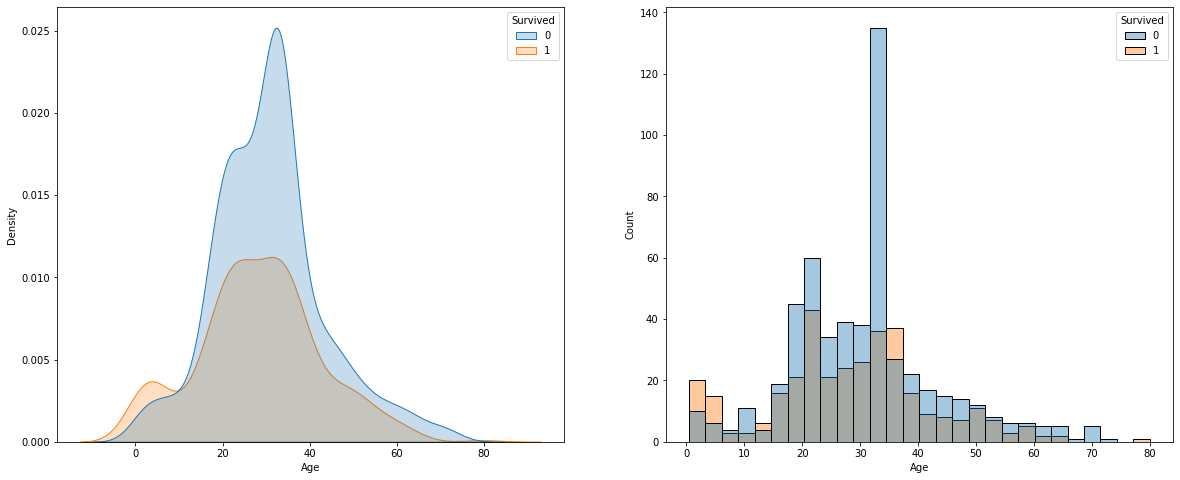

In [60]:
# Subplot the histogram and KDE of age 
fig,ax=plt.subplots(1,2,figsize=(20,8))
sns.kdeplot(data=train_df,x='Age',hue='Survived',fill=True, ax=ax[0])
sns.histplot(data=train_df,x='Age',hue='Survived', alpha=0.4 ,ax=ax[1])
plt.show()

From the plots, it seems like most of the passengers of age 20-40 has lower survival rate compared to the other age group. Also, passengers from age 0-10 has higher survival rate, thus age is also most likely a important feature to be selected.

#### SibSp

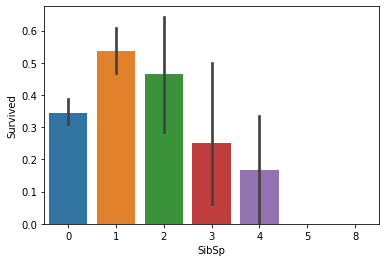

In [61]:
# Plot barchart of SibSp vs Survived
sns.barplot(data=train_df, x='SibSp',y='Survived')
plt.show()

In [62]:
# Groupby SibSp to get the mean of survival rate
train_df.groupby('SibSp', as_index=False).Survived.mean().sort_values(by='Survived',ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


Looking at SibSp, it seems like the higher number of siblings, the lower the chances of survival. Thus SibSp should also be in the feature selection.

#### Parch

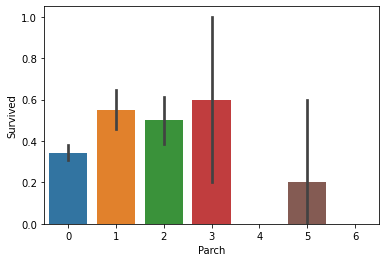

In [63]:
# Plot barchart of Parch vs Survived
sns.barplot(data=train_df, x='Parch', y='Survived')
plt.show()

In [64]:
# Group Parch to get the mean of survival rate
train_df.groupby('Parch', as_index=False).Survived.mean().sort_values(by='Survived',ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


Generally it seems like there is not much trend in the Parch columns, however, passengers with >0 Parch has a higher survivability which then goes down when the number gets too high

#### Ticket

Same as the name column, the ticket column does not provide any useful information that can be used to predict the survivability of the passenger. Thus this column will be dropped.

#### Fare

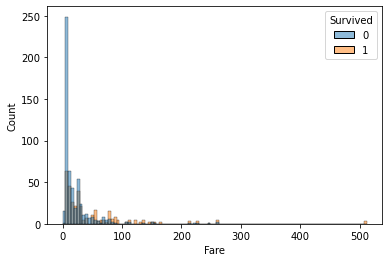

In [65]:
# Plot histogram of Fare with Survived as hue
sns.histplot(data=train_df, x='Fare', hue='Survived')
plt.show()

The Fare histogram indicates that passengers who paid a higher fare had a better chance of surviving compared to those who paid a lower fare. This correlation is likely linked to the Pclass of the tickets, as previously shown in the plot, where a higher Pclass is associated with a greater likelihood of survival.

#### Cabin

Cabin is the different passengers room assigned. It could be useful to use as a feature, however, cabin has 687 missing rows which can be difficult to impute and eventually lead to inaccuracy. Thus cabin will be dropped as well.

#### Embarked

There are 2 missing entry of Embarked, **Stone, Mrs. George Nelson (Martha Evelyn)** and **Amelie Icard**. With a simple google search, I was able to find their port of embark which is Southampton. 

"Mrs Stone boarded the Titanic in Southampton on 10 April 1912 and was travelling in first class with her maid Amelie Icard. She occupied cabin B-28."

In [66]:
# Locate NaN entry for embarked
train_df.loc[train_df['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Miss
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Mrs


In [67]:
# Fill in Southampton as their embarked location
train_df['Embarked'] = train_df['Embarked'].fillna('S')

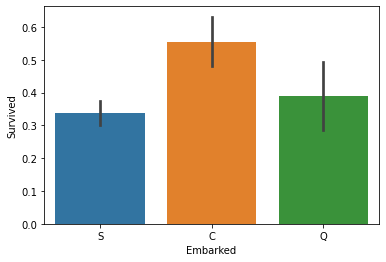

In [68]:
# Plot barchart of Embarked vs Survived
sns.barplot(data=train_df, x='Embarked', y='Survived')
plt.show()

In [69]:
# Group by Embarked to get the mean of survival rate
train_df.groupby('Embarked',as_index=False).Survived.mean()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


From the plot, it seems that passengers who embarked from Cherbourgh has a higher survival rate. Thus this will be also used as a feature.

<a id="subsection-four"></a>
### Transforming data

The different types of features can be categorized into two main groups: **categorical** and **continuous**.\
Categorical features are variables that have two or more categories. When these variables cannot be sorted or ordered, it is known as **nominal** variables. Examples of nominal features in the dataset include sex and embarked. However, when they can be sorted or ordered based on their relative values, they are known as **ordinal** features. For instance, the height feature with values tall, medium, and short is an ordinal variable because it can be sorted based on relative height. An example of an ordinal feature in the dataset is PClass.

Finally, continuous features are those that can take any value between the minimum and maximum values of the feature column. These features are referred to as continuous because they can take on an infinite number of values within a given range. An example of continuous feature in this dataset is Fare.

In [70]:
# Onehotencode nominal features for train_df

# Create an instance of the encoder
onehot_encoder = OneHotEncoder()

# Fit the encoder to the 'Sex' column and transform the data
sex_onehot = onehot_encoder.fit_transform(train_df['Sex'].values.reshape(-1,1)).toarray()
sex_df = pd.DataFrame(sex_onehot, columns=['female', 'male'])
train_df = pd.concat([train_df, sex_df], axis=1)

# Fit the encoder to the 'Embarked' column and transform the data
embarked_onehot = onehot_encoder.fit_transform(train_df['Embarked'].values.reshape(-1,1)).toarray()
embarked_df = pd.DataFrame(embarked_onehot, columns=['C', 'Q', 'S'])
train_df = pd.concat([train_df, embarked_df], axis=1)

In [71]:
# Onehotencode nominal features for test_df
# Fit the encoder to the 'Sex' column and transform the data
sex_onehot = onehot_encoder.fit_transform(test_df['Sex'].values.reshape(-1,1)).toarray()
sex_df = pd.DataFrame(sex_onehot, columns=['female', 'male'])
test_df = pd.concat([test_df, sex_df], axis=1)

# Fit the encoder to the 'Embarked' column and transform the data
embarked_onehot = onehot_encoder.fit_transform(test_df['Embarked'].values.reshape(-1,1)).toarray()
embarked_df = pd.DataFrame(embarked_onehot, columns=['C', 'Q', 'S'])
test_df = pd.concat([test_df, embarked_df], axis=1)

In [72]:
# Dropping not related features
cols_to_drop = ['PassengerId','Name','Ticket','Cabin','Initial','Sex','Embarked',]
train_df = train_df.drop(columns=cols_to_drop)
test_df = test_df.drop(columns=cols_to_drop)

Lets take a final look at our data before going on to modelling

In [73]:
train_df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,female,male,C,Q,S
0,0,3,22.0,1,0,7.2500,0.0,1.0,0.0,0.0,1.0
1,1,1,38.0,1,0,71.2833,1.0,0.0,1.0,0.0,0.0
2,1,3,26.0,0,0,7.9250,1.0,0.0,0.0,0.0,1.0
3,1,1,35.0,1,0,53.1000,1.0,0.0,0.0,0.0,1.0
4,0,3,35.0,0,0,8.0500,0.0,1.0,0.0,0.0,1.0


<a id="section-three"></a>
## Modelling and predicting

Having completed our exploratory data analysis, we now turn our attention to building a predictive model to help us understand the relationships between various features and the likelihood of survival on the Titanic. Our goal is to identify the best algorithm that can classify the passengers into survivors and non-survivors with high accuracy, using the insights gained from the EDA. 

We have selected several supervised learning algorithms to evaluate their performance in solving this classification problem as follows:

1) Logistic regression
2) k-Nearest Neighbors
3) Support vector machine
4) Decision tree 
5) Random forest
6) XGBoost

By leveraging the strengths of these algorithms and fine-tuning their parameters, we aim to build a model that can accurately predict the survival of passengers on the Titanic.

In [74]:
# Splitting train_df to train test split
X_train, X_test, y_train, y_test = train_test_split(train_df.drop(columns='Survived'),train_df['Survived'],test_size=0.2,random_state=50)

# Scaling the data
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
test_df = scaler.transform(test_df)

In [75]:
# Fit logistic regression model and predict
lrmodel = LogisticRegression(max_iter=500)
lrmodel.fit(X_train,y_train)
lr_pred = lrmodel.predict(X_test)

# Accuracy of logistic regression model 
lr_acc = accuracy_score(y_test,lr_pred)
print("Accuracy for logistic regression:", lr_acc)

Accuracy for logistic regression: 0.7988826815642458


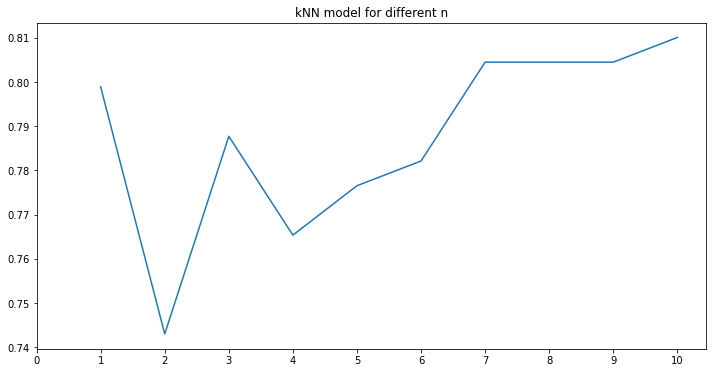

Accuracy for best n kNN model: 0.8100558659217877


In [76]:
# Fit k_Nearest Neighbors and predict for different n neighbors
knn_index = list(range(1, 11))
knn = pd.Series(dtype=float)
x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
knn_lst = []
for i in list(range(1, 11)):
    knnmodel = KNeighborsClassifier(n_neighbors=i) 
    knnmodel.fit(X_train, y_train)
    knn_pred = knnmodel.predict(X_test)
    knn_lst.append(accuracy_score(knn_pred, y_test))

knn = pd.concat([knn, pd.Series(knn_lst)])

plt.figure(figsize=(12, 6))
plt.plot(knn_index, knn)
plt.xticks(x)
plt.title("kNN model for different n")
plt.show()
print('Accuracy for best n kNN model:' , knn.values.max())


In [77]:
# Fit support vector machine and predict

# Linear SVM
lsvm = LinearSVC(max_iter=5000)
lsvm.fit(X_train,y_train)
lsvm_pred = lsvm.predict(X_test)

# RBF SVM
rbfsvm = SVC(kernel="rbf")
rbfsvm.fit(X_train,y_train)
rbfsvm_pred = rbfsvm.predict(X_test)

# Polynomial SVM
polysvm = SVC(kernel="poly")
polysvm.fit(X_train,y_train)
polysvm_pred = polysvm.predict(X_test)

# Accuracy for SVMs
lsvm_acc = accuracy_score(y_test,lsvm_pred)
rbfsvm_acc = accuracy_score(y_test,rbfsvm_pred)
polysvm_acc = accuracy_score(y_test,polysvm_pred)

print("Accuracy for Linear SVM:", lsvm_acc)
print("Accuracy for RBF SVM:", rbfsvm_acc)
print("Accuracy for Polynomial SVM:", polysvm_acc)

Accuracy for Linear SVM: 0.7932960893854749
Accuracy for RBF SVM: 0.8100558659217877
Accuracy for Polynomial SVM: 0.7988826815642458


In [78]:
# Decision tree
treemodel = DecisionTreeClassifier()
treemodel.fit(X_train,y_train)
treemodel_pred = treemodel.predict(X_test)

# Accuracy of Decision tree
treemodel_acc = accuracy_score(y_test,treemodel_pred)
print("Accuracy of Decision tree:", treemodel_acc)

Accuracy of Decision tree: 0.7821229050279329


In [79]:
# Random forest
forestmodel = RandomForestClassifier()
forestmodel.fit(X_train,y_train)
forestmodel_pred = forestmodel.predict(X_test)

# Accuracy of Random forest
forestmodel_acc = accuracy_score(y_test,forestmodel_pred)
print("Accuracy of Random forest:", forestmodel_acc)

Accuracy of Random forest: 0.8156424581005587


In [80]:
# XGBoost
XGBmodel = XGBClassifier(n_estimators=100, early_stopping_rounds=5)
XGBmodel.fit(X_train,y_train, eval_set=[(X_test, y_test)],verbose=False)
XGBmodel_pred = XGBmodel.predict(X_test)

# Accuracy of XGBoost
XGBmodel_acc = accuracy_score(y_test,XGBmodel_pred)
print("Accuracy of XGBoost:", XGBmodel_acc)


Accuracy of XGBoost: 0.8044692737430168


<a id="subsection-five"></a>
### Cross Validation

Cross-validation (CV) is a technique used in machine learning to evaluate the performance of a model. In simple modelling, we typically split our dataset into training and testing sets and evaluate the model's performance on the testing set. However, this approach has some limitations, such as a high variance in the evaluation metric, which could lead to overfitting or underfitting of the model. Cross-validation provides a more robust and reliable way to assess model performance by splitting the data into multiple folds and training the model on different subsets of the data. This allows us to obtain a more stable estimate of the model's performance and reduce the risk of overfitting or underfitting. In this way, cross-validation helps us to ensure that our model is generalizable and performs well on new, unseen data.


In [81]:
# Define the models to be tested
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
    "KNN": KNeighborsClassifier(),
    "RBF SVM": SVC(kernel='rbf'),
    "Decision Tree": DecisionTreeClassifier()
}

# Define the hyperparameters to be tested for each model
params = {
    "Logistic Regression": {
        "C": [0.1, 1.0, 10.0],
        "solver": ["lbfgs", "liblinear"]
    },
    "Random Forest": {
        "n_estimators": [10, 50, 100],
        "max_depth": [None, 5, 10],
        "min_samples_split": [2, 5, 10]
    },
    "XGBoost": {
        "learning_rate": [0.01, 0.1, 0.5],
        "n_estimators": [50, 100, 200],
        "max_depth": [3, 5, 7],
        "subsample": [0.5, 0.7, 1.0],
        "colsample_bytree": [0.5, 0.7, 1.0]
    },
    "KNN": {
        "n_neighbors": [2, 4, 6, 8, 10],
        "weights": ["uniform", "distance"]
    },
    "RBF SVM": {
        "C": [0.1, 1.0, 10.0],
        "gamma": [0.01, 0.1, 1.0]
    },
    "Decision Tree": {
        "max_depth": [None, 5, 10],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    }
}

# Define the number of folds for cross-validation
k = 5
cv = KFold(n_splits=k, shuffle=True, random_state=42)

# Perform grid search for each model
for model_name, model in models.items():
    print(f"Performing grid search for {model_name}...")
    grid_search = GridSearchCV(
        model,
        params[model_name],
        cv=cv,
        scoring="accuracy",
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Training accuracy: {grid_search.best_score_:.3f}")
    print(f"Test accuracy: {grid_search.score(X_test, y_test):.3f}")


Performing grid search for Logistic Regression...
Best parameters: {'C': 1.0, 'solver': 'lbfgs'}
Training accuracy: 0.796
Test accuracy: 0.799
Performing grid search for Random Forest...
Best parameters: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 50}
Training accuracy: 0.834
Test accuracy: 0.804
Performing grid search for XGBoost...
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.7}
Training accuracy: 0.833
Test accuracy: 0.821
Performing grid search for KNN...
Best parameters: {'n_neighbors': 8, 'weights': 'uniform'}
Training accuracy: 0.827
Test accuracy: 0.804
Performing grid search for RBF SVM...
Best parameters: {'C': 10.0, 'gamma': 0.1}
Training accuracy: 0.833
Test accuracy: 0.804
Performing grid search for Decision Tree...
Best parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10}
Training accuracy: 0.824
Test accuracy: 0.777


<a id="section-four"></a>
## Submission

In [82]:
# Predictions using XGBoost for test_df and output for submission

#Train the XGBoost model with the best parameters
model = XGBClassifier(
    learning_rate=0.1,
    max_depth=5,
    n_estimators=100,
    subsample=0.7,
    colsample_bytree=1.0)

model.fit(X_train, y_train)

predictions =  model.predict(test_df)
test_data = pd.read_csv('test.csv')
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


<a id="section-five"></a>
## Conclusion

For this Titanic dataset, I started by performing exploratory data analysis using Seaborn to visualize various features and their relationship with the target variable. Through this process, I was able to identify several features that seemed to have a significant impact on survival rate, including sex, class, and age. I also filled in missing values for age and embarked location using appropriate methods.

Next, I selected relevant features for the model based on the EDA. For categorical variables, I one-hot encoded nominal variables and left ordinal variables untouched. I then used three classification models - logistic regression, random forest, and XGBoost - as well as KNN, RBF SVM, and decision tree, and performed grid search cross-validation to find the best hyperparameters for each model.

From the results, the XGBoost model performed the best with an accuracy of 0.821. Additionally, I was able to obtain a better understanding of the importance of each feature in predicting survival rate, with age, sex, and class being the most important features.

Overall, this project provided me with valuable experience in exploring and preparing data, selecting relevant features, and building and optimizing machine learning models.